<a href="https://colab.research.google.com/github/scottthomaswx/Great-Lakes-WW3/blob/main/GreatLakesWaveWatchIII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Load and import packages
%%capture
!pip install numpy
!pip install xarray[complete]
!pip install metpy
!pip install matplotlib
!pip install cartopy
!pip install datetime
!pip install requests
!pip install pyproj
!pip install pandas
!pip install cfgrib
!apt-get install -y libeccodes0
!pip install cfgrib xarray
!pip install sys
!pip install warnings
import xarray as xr
import numpy as np
import metpy
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from datetime import datetime
import requests
import cartopy.crs as ccrs
from metpy.plots import USCOUNTIES
from metpy.plots import add_timestamp
import pyproj as proj
import pandas as pd
import sys
import warnings
import matplotlib.animation as animation
warnings.filterwarnings('ignore')

In [ ]:
#Get and Save WaveWatch III Data
WW = 'https://www.glerl.noaa.gov/emf/waves/WW3/images/nomads.grib2'
r1 = requests.get(WW)
file1='/content/ww.grib2'
with open(file1, 'wb') as f1:
                f1.write(r1.content)

In [ ]:
%%capture
ww3 = xr.open_dataset(file1, engine="cfgrib")
swh = ww3.metpy.parse_cf('swh').metpy.convert_units('ft')

#Map of Wavewatch III Data


In [ ]:
%%capture
!mkdir FcstHourFiles
float_formatter = "{:03d}".format
i=0
rounded = np.array(swh.time, dtype='datetime64[m]')
while i <  len(ww3['valid_time']):
    #Create Figure and Subplot
    fig = plt.figure(figsize=(14,8), facecolor='white', edgecolor = 'black', linewidth = 6)

    ax=fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

    #Create Wave Contours
    wave_fill = ax.contourf(swh.longitude,swh.latitude,swh.isel(step=i), cmap='viridis_r', levels = np.arange(0,21,1), zorder=7, transform=ccrs.PlateCarree())
    wave_cont = ax.contour(swh.longitude,swh.latitude,swh.isel(step=i), color='black', levels = np.arange(0,21,1), zorder=7, transform=ccrs.PlateCarree())
    wavelabels= ax.clabel(wave_cont, fmt='%01d', fontsize = 'large', colors = 'black')

    #Plot and SUbplot Settings
    plt.colorbar(wave_fill, orientation='vertical',pad=0.02, aspect=50, shrink=0.935, label = 'Wave Height (ft)')
    plt.figtext(0.125, 0.08, f'SCOTT THOMAS | SOURCE: GLERL', weight='bold', color='black', fontsize=16, ha='left', alpha=0.8)
    plt.figtext(0.13, 0.905, f'WW3 Significant Wave Height (Feet)', ha='left', weight='bold', fontsize=15)
    plt.figtext(0.13, 0.875, f'Runtime: {rounded} at FHR: {i}', ha='left', weight='bold', fontsize=12)
    ax.coastlines(color='black',resolution='10m',zorder=99)
    ax.add_feature(cfeature.STATES.with_scale('50m'),edgecolor='black', zorder=9, facecolor = 'grey')

    #Adjust Lat/Long To Map
    ax.set_extent((-88.25,-81,41.5,46.25))
    add_timestamp(ax, swh['valid_time'][i].values.astype('datetime64[ms]').astype('O'),
                  y=0.02, high_contrast=True, color = 'white', pretext = 'Valid: ', zorder=10)
    #Save Figure
    plt.savefig('/content/FcstHourFiles/WW3_FHR'+str(float_formatter(i))+'.png', dpi=100, bbox_inches='tight')
    i+=1

**Station Timeseries**

In [ ]:
#Pull Bouy Lat/Long Estimate via grid resolution
#Credit to Kyle Gillett for development of the buoy lat/long method
def buoy_latlon(buoy_site):

    '''
        takes a BUOY/CMAN site id such as '41001', searches through a number of station IDs and returns
        a list including the lat/lon for the BUOY/CMAN  site

    '''

    def dms2dd(degrees, direction):
        dd = float(degrees)
        if direction == "S" or direction == "W":
            dd *= -1
        return dd
    BUOY_STATIONS = pd.read_csv(r'https://raw.githubusercontent.com/scottthomaswx/Marine-Meteogram-Plotter/main/BUOY-STATIONS.txt', skiprows=7, skipinitialspace = True, index_col=False)
    try:
        station = BUOY_STATIONS['ID'][np.where(BUOY_STATIONS['ID'].str.contains(buoy_site, na=False, case=True))[0]].values[0]

        lat = dms2dd(BUOY_STATIONS[BUOY_STATIONS['ID']==station]['LAT'].values[0], BUOY_STATIONS[BUOY_STATIONS['ID']==station]['A'].values[0])
        lon = dms2dd(BUOY_STATIONS[BUOY_STATIONS['ID']==station]['LON'].values[0], BUOY_STATIONS[BUOY_STATIONS['ID']==station]['B'].values[0])
        return [lat, lon]

    except:
        sys.exit("NO BUOY SITE FOUND FOR THAT ID -- Make sure you entered a valid BUOY ID -- Make sure you entered the BUOY ID as a string, ex: '41001'")
        pass

In [ ]:
# @markdown # Enter the buoy ID of the site you wish to see data for
# @markdown ### Find bouys at: https://www.ndbc.noaa.gov/
station = '45007' #@param {type:"string"}
latitude, longitude = buoy_latlon(station)
LatArray = []
q=0
while q < 376:
    LatArray.append(40.52091900000 + 0.02308821 * q)
    q+=1
LonArray= []
z=0
while z < 597:
    LonArray.append(-92.63547500000 + 0.030841831 * z)
    z+=1
sely = min(range(len(LatArray)), key=lambda i: abs(LatArray[i]-latitude))
selx = min(range(len(LonArray)), key=lambda i: abs(LonArray[i]- longitude))

In [ ]:
NoneWave_Time = []
NoneWave_Hgt = []
SCYWave_Time = []
SCYWave_Hgt = []
F8_Time = []
F8_Hgt = []
F10_Time = []
F10_Hgt = []
F15_Time = []
F15_Hgt = []
F20_Time = []
F20_Hgt = []
a=0
sitewave = swh.isel(x = selx, y = sely)
l=0
while l < 149:
    #Wave Check
    if sitewave.isel(step=l).values >= 4 and sitewave.isel(step=l).values <8 :
        SCYWave_Time.append(a)
        SCYWave_Hgt.append((sitewave.values[a]))
    elif sitewave.isel(step=l).values <4:
        NoneWave_Time.append(a)
        NoneWave_Hgt.append((sitewave.values[a]))
    elif sitewave.isel(step=l).values >=8 and sitewave.isel(step=l).values <10:
        F8_Time.append(a)
        F8_Hgt.append((sitewave.values[a]))
    elif sitewave.isel(step=l).values >=10 and sitewave.isel(step=l).values <15:
        F10_Time.append(a)
        F10_Hgt.append((sitewave.values[a]))
    elif sitewave.isel(step=l).values >=15 and sitewave.isel(step=l).values <20:
        F15_Time.append(a)
        F15_Hgt.append((sitewave.values[a]))
    elif sitewave.isel(step=l).values >=20:
        F20_Time.append(a)
        F20_Hgt.append((sitewave.values[a]))
    a+=1
    l+=1

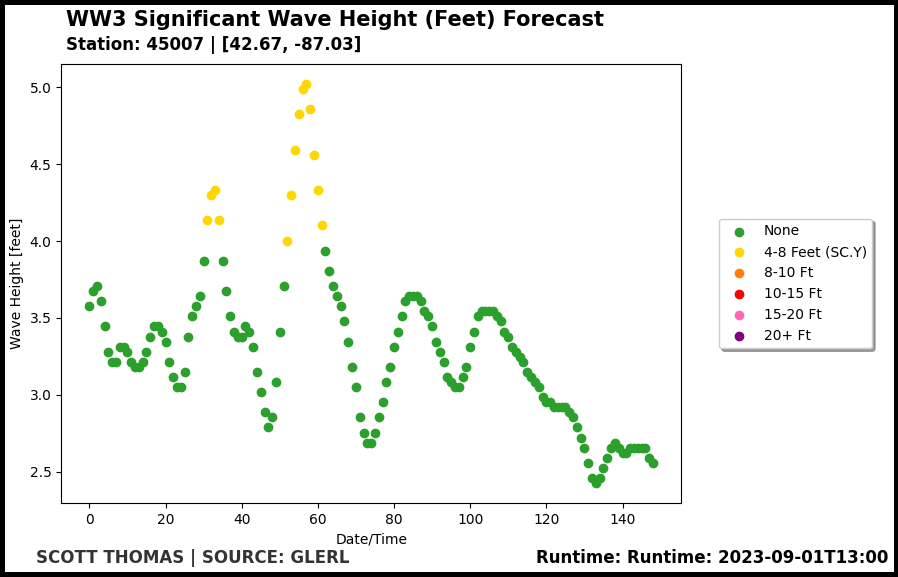

In [ ]:
#Plot Timeseries
rounded = np.array(swh.time, dtype='datetime64[m]')
fig = plt.figure(figsize=(10,6), facecolor='white', edgecolor = 'black', linewidth = 6)
plt.figtext(0.13, 0.905, f'WW3 Significant Wave Height (Feet) Forecast', ha='left', weight='bold', fontsize=15)
plt.figtext(0.13, 0.865, f'Station: {station} | {buoy_latlon(station)}', ha='left', weight='bold', fontsize=12)
plt.figtext(0.6, 0.01, f'Runtime: {rounded}', ha='left', weight='bold', fontsize=12)


# Wave Height
ax1 = plt.subplot(1, 1,1)
ax1.scatter(NoneWave_Time, NoneWave_Hgt, color = 'tab:green', label = 'None')
ax1.scatter(SCYWave_Time, SCYWave_Hgt, color = 'gold', label = '4-8 Feet (SC.Y)')
ax1.scatter(F8_Time, F8_Hgt, color = 'tab:orange', label = '8-10 Ft')
ax1.scatter(F10_Time, F10_Hgt, color = 'red', label = '10-15 Ft')
ax1.scatter(F15_Time, F15_Hgt, color = 'hotpink', label = '15-20 Ft')
ax1.scatter(F20_Time, F20_Hgt, color = 'purple', label = '20+ Ft')
ax1.set_ylabel('Wave Height [feet]')
ax1.set_xlabel('Date/Time')
box1 = ax1.get_position()
ax1.set_position([box1.x0, box1.y0, box1.width * 0.8, box1 .height*0.95])
ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
    ncol=1, fancybox=True, shadow=True)

plt.figtext(0.1, 0.01, f'SCOTT THOMAS | SOURCE: GLERL', weight='bold', color='black', fontsize=12, ha='left', alpha=0.8)
plt.savefig(str(station)+'_ww3cast.png')
